This notebook demonstrates fine-tuning a DistilBERT model to predict movie genres from descriptions, using the IMDB Movie Data. Our goal is to navigate the challenges of a multi-label classification task with a straightforward approach.
Dataset

We use the IMDB Movie Data focusing on Description and Genre columns. Each movie has multiple genres, making this a multi-label classification problem.
Approach
Tokenization

We directly tokenize the movie descriptions using DistilBERT's tokenizer without additional text cleaning, preparing the data for the model.
Model Training

We choose DistilBERT for its efficiency. The fine-tuning involves:

    Tokenizing descriptions to a uniform length.
    Creating a custom dataset for encoded texts and labels.
    Training DistilBERT with a multi-label classification setup.

Memory Management

We manage GPU memory by clearing unused cache, crucial for handling resource-intensive models like DistilBERT.
Results

We evaluate our model's performance and demonstrate its capability to predict genres on new descriptions.
Conclusion

Fine-tuning DistilBERT enabled us to build a model capable of genre prediction from movie descriptions. This showcases the potential of transformer models in handling multi-label NLP tasks.


Additional Resources

For more insights into NLP model training and fine-tuning, check out:

    https://www.youtube.com/watch?v=ZYc9za75Chk&t=118s
    https://huggingface.co/docs/transformers/training

In [25]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/imdb-data/IMDB-Movie-Data.csv


In [26]:
# importations des bibliothèques
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_auc_score,f1_score,hamming_loss,precision_score,recall_score
from transformers import EvalPrediction

In [27]:
# read data

df = pd.read_csv("/kaggle/input/imdb-data/IMDB-Movie-Data.csv", usecols=["Description", "Genre"])
df.head()

,Genre,Description
0,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...
1,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te..."
2,"Horror,Thriller",Three girls are kidnapped by a man with a diag...
3,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea..."
4,"Action,Adventure,Fantasy",A secret government agency recruits some of th...


In [28]:
# check nan values
print(df.shape,"\n\n",df.isna().sum())

(1000, 2) 

 Genre          0
Description    0
dtype: int64


In [29]:
# describe the number of tokens to set the (max_len for the tokenizer)
df["len_description"] = [len(i) for i in (df.Description)]
df.len_description.describe()

count    1000.000000
mean      163.232000
std        49.578586
min        42.000000
25%       128.000000
50%       159.000000
75%       200.000000
max       421.000000
Name: len_description, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


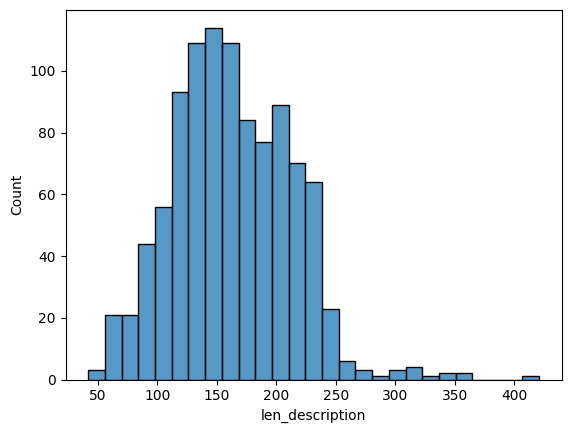

In [30]:
sns.histplot(data=df,x=df.len_description)
plt.show()

In [31]:
# list of genre in the dataset
count_genre = pd.Series([genre for liste_genre in df.Genre.str.split(",") for genre in liste_genre])
count_genre.value_counts()

Drama        513
Action       303
Comedy       279
Adventure    259
Thriller     195
Crime        150
Romance      141
Sci-Fi       120
Horror       119
Mystery      106
Fantasy      101
Biography     81
Family        51
Animation     49
History       29
Sport         18
Music         16
War           13
Western        7
Musical        5
Name: count, dtype: int64

In [32]:
# Importing the necessary library for binarizing the labels
from sklearn.preprocessing import MultiLabelBinarizer

# Splitting the movie genres
# This operation converts the string of comma-separated genres into a list of genres.
# For example, "Action,Adventure,Sci-Fi" becomes ["Action", "Adventure", "Sci-Fi"].
# This is necessary to be able to treat each genre as a separate category in the following analysis.
print(df.Genre.str.split(","))

0       [Action, Adventure, Sci-Fi]
1      [Adventure, Mystery, Sci-Fi]
2                [Horror, Thriller]
3       [Animation, Comedy, Family]
4      [Action, Adventure, Fantasy]
                   ...             
995         [Crime, Drama, Mystery]
996                        [Horror]
997         [Drama, Music, Romance]
998             [Adventure, Comedy]
999       [Comedy, Family, Fantasy]
Name: Genre, Length: 1000, dtype: object


In [33]:

# Each column represents a specific genre, and each row represents a movie.
# If a movie belongs to a given genre, the corresponding cell is marked with a 1 (otherwise, it's marked with a 0).
# This allows treating the problem as a multi-label classification task.
multilabel = MultiLabelBinarizer()

# Applying MultiLabelBinarizer on the split genres
# The result is a binary matrix indicating the presence or absence of each genre for each movie.
# .astype("float32") is used to convert the data type to float32, which might be required for certain machine learning models.
labels = multilabel.fit_transform(df["Genre"].str.split(',')).astype("float32")

# Preparing the movie descriptions for analysis
# Converts the column of descriptions into a list, where each element corresponds to one movie's description.
# This list will be used as input for NLP or machine learning models to predict the genres based on the descriptions.
text = df.Description.tolist()


In [34]:
print("nombre de labels : ",len(count_genre.value_counts()))
print("-----")
print(labels.shape)
print("---------")
print(labels)

nombre de labels :  20
-----
(1000, 20)
---------
[[1. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [35]:
## model
from transformers import DistilBertTokenizer,AutoTokenizer
from transformers import DistilBertForSequenceClassification, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,Dataset

In [36]:
# splitting data for train and test
X_train,X_test,y_train,y_test = train_test_split(text,labels,
                                                test_size=0.2,random_state=42)

In [37]:
# Define the checkpoint for the model we intend to use - DistilBERT base model (uncased version).
checkpoint = "distilbert-base-uncased"

# Initialize the tokenizer for DistilBERT from the pre-defined checkpoint.
# The tokenizer is responsible for converting text into a format that's compatible with the model.
tokenizer = DistilBertTokenizer.from_pretrained(checkpoint)

# Initialize the model for sequence classification from the DistilBERT checkpoint.
# We specify the number of labels based on our dataset's unique genres (the width of the binary matrix 'labels').
# The problem is defined as "multi_label_classification" to handle multiple genres per movie.
model = DistilBertForSequenceClassification.from_pretrained(checkpoint, num_labels=len(labels[0]), problem_type="multi_label_classification")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# Calculate median description length for consistent max sequence length.
max_len = int(df.len_description.describe()['50%']) 
print(max_len)

# Tokenize training data to fixed max_len, adding truncation and padding as needed.
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=max_len)

# Tokenize test data similar to training data for consistency.
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=max_len)


159


In [39]:
class Custom_Dataset(torch.utils.data.Dataset):
    # Initialize dataset with tokenized encodings and corresponding labels.
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    # Return a single encoded item and its label by index.
    def __getitem__(self, idx):
        # Convert each encoding at index 'idx' to a PyTorch tensor.
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Convert the label at index 'idx' to a PyTorch tensor.
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    # Return the total number of items in the dataset.
    def __len__(self):
        return len(self.labels)



In [40]:
# Create a training dataset by passing the tokenized training encodings and labels.
train_data = Custom_Dataset(train_encodings, y_train)

# Create a test dataset similarly with tokenized test encodings and test labels.
test_data = Custom_Dataset(test_encodings, y_test)


In [41]:
train_data[0]

{'input_ids': tensor([  101,  2043, 15229, 11404, 15102,  1996,  5758,  1997,  2010, 13032,
         12943, 19231,  2906,  1998, 12154,  1996,  4813,  1997,  1037,  3040,
         12025,  1010,  2002,  9418,  2002,  2003,  1037, 12608,  1997,  1996,
          3595, 18364,  2554,  1012,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [42]:
def multi_label_metrics(predictions, labels, threshold=0.5):
    # Activation sigmoid pour convertir les logits en probabilités
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    
    # Appliquer le seuil directement avec PyTorch
    y_pred = (probs >= threshold).float()
    
    # Conversion en NumPy pour les métriques scikit-learn, si nécessaire
    y_pred_np = y_pred.numpy()
    # Pas besoin de convertir 'labels' puisqu'il est déjà un numpy array
    y_true_np = labels  # Utilisez directement labels sans .numpy()
    
    # Calcul des métriques
    f1 = f1_score(y_true_np, y_pred_np, average='micro')
    roc_auc = roc_auc_score(y_true_np, y_pred_np, average='micro')
    hamming = hamming_loss(y_true_np, y_pred_np)
    precision = precision_score(y_true_np, y_pred_np, average='micro')
    recall = recall_score(y_true_np, y_pred_np, average='micro')

    return {
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC Score': roc_auc,
        'Hamming Loss': hamming,
    }

def compute_metrics(p:EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multi_label_metrics(predictions=preds, labels=p.label_ids)
    return result


In [43]:
## Training Model
import os
os.environ["WANDB_API_KEY"] = "YOUR_API_KEY"

In [44]:
from transformers import Trainer, TrainingArguments

In [45]:
## test 2 
training_args = TrainingArguments (
    
    output_dir='./results',          # output directory
    num_train_epochs=5,              # total number of training epochs
    per_device_train_batch_size=32,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    save_steps= 1000,
    save_total_limit=2
)

In [46]:
## test2
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_data,         # training dataset
    eval_dataset= test_data,        # evaluation dataset
    compute_metrics= compute_metrics)  ## metrics


In [47]:
# Loop over the specified number of training epochs.
for epoch in range(training_args.num_train_epochs):
    # Train the model for one epoch.
    trainer.train()
    
    # Empty the GPU cache to free unused memory.
    torch.cuda.empty_cache()


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss


Step,Training Loss


Step,Training Loss


Step,Training Loss


Step,Training Loss


In [48]:
trainer.evaluate()

{'eval_loss': 0.2480146437883377,
 'eval_Precision': 0.6824512534818942,
 'eval_Recall': 0.47572815533980584,
 'eval_F1 Score': 0.5606407322654462,
 'eval_ROC AUC Score': 0.7215082670529732,
 'eval_Hamming Loss': 0.096,
 'eval_runtime': 0.2898,
 'eval_samples_per_second': 690.174,
 'eval_steps_per_second': 6.902,
 'epoch': 5.0}